Install dependencies

In [30]:
!source .venv/bin/activate
!pip install -r requirements.txt

  Using cached appnope-0.1.4-py2.py3-none-any.whl.metadata (908 bytes)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached bleach-6.1.0-py3-none-any.whl.metadata (30 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
  Using cached charset_normalizer-3.4.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (34 kB)
  Using cached contourpy-1.3.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached exceptiongroup-1.2.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached executing-2.1.0-py2.py3-none-any.whl.metadata (8.9 kB)
  Using cached fonttools-4.54.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached ipykernel-5.5.6-py3-none-any.whl.metadata (1.1 kB)
  Using cached ipython-8.28.0-py3-none-any.whl.metadata (5.0 kB)
  Using ca

In [13]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()

dataset_path = 'datasets/datamunge/sign-language-mnist'
dataset_files = [x for x in os.listdir(dataset_path) if x != '.DS_Store']
if not dataset_files:
    api.dataset_download_files("datamunge/sign-language-mnist", path=dataset_path, unzip=True)
    print("Dataset has been downloaded into ", dataset_path)
else:
    print("Dataset is already downloaded into ", dataset_path)

Dataset is already downloaded into  datasets/datamunge/sign-language-mnist


In [33]:
import pandas as pd
import numpy as np


train = pd.read_csv(f'{dataset_path}/sign_mnist_train.csv')
test = pd.read_csv(f'{dataset_path}/sign_mnist_test.csv')

train_data = np.array(train, dtype = 'float32') # todo: change type to int
test_data = np.array(test, dtype='float32') # todo: change type to int

numeric_labels = list(range(26))
numeric_to_alpha_label_map = {numeric_label: chr(65 + numeric_label) for numeric_label in numeric_labels}

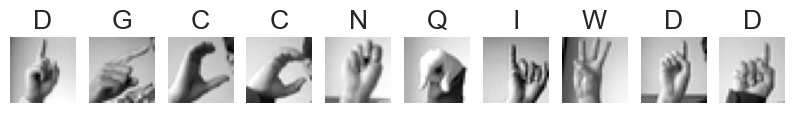

In [35]:
import math
import matplotlib.pyplot as plot

# plot the first 10 images
number_imags_to_plot = 10
img_size = 10
fig, axes = plot.subplots(1, number_imags_to_plot, figsize=(img_size, img_size))
for i, ax in enumerate(axes):
    numeric_label, *img_1d = train_data[i]
    img_1d = np.array(img_1d)
    img_pixel_count = img_1d.shape[0]
    edge_size = int(math.sqrt(img_pixel_count))
    ax.imshow(img_1d.reshape((edge_size, edge_size)), cmap='gray')
    alpha_label = numeric_to_alpha_label_map[numeric_label]
    ax.set_title(alpha_label)
    ax.axis('off')


train.shape: (27455, 785)
test.shape: (7172, 785)


Text(0.5, 1.0, 'Label')

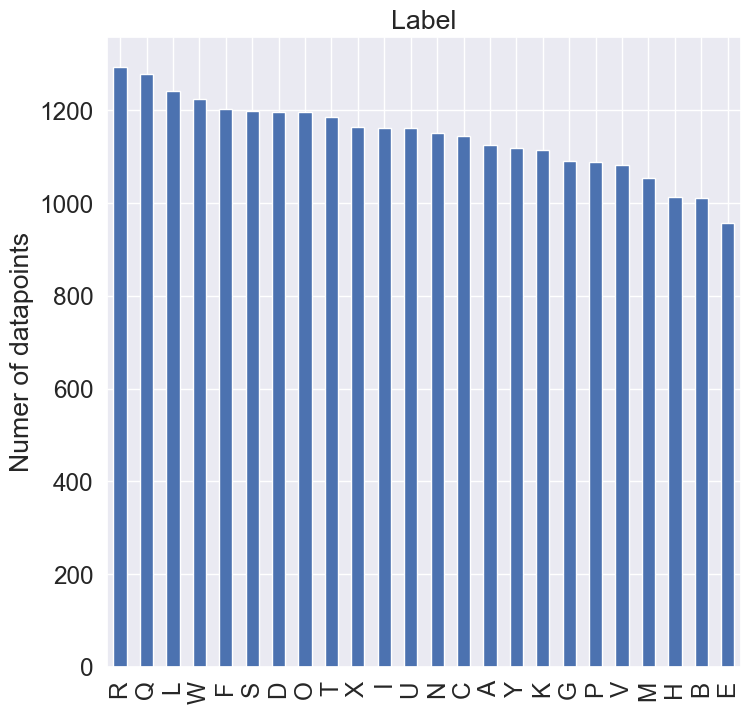

In [36]:
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")

# Show distribution of train data
distribution = train['label'].value_counts(sort=True)
distribution.index = [ numeric_to_alpha_label_map[x] for x in distribution.index]
fig = plot.figure(figsize=(18,18))
ax1 = fig.add_subplot(221)
distribution.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Numer of datapoints')
ax1.set_title('Label')

Implement model:
TODO